# Sentiment Analysis using BERT

CODE ALMOST ALL FROM: https://www.kaggle.com/code/prakharrathi25/sentiment-analysis-using-bert
THE DATASET I USED: https://github.com/dxlabskku/Mental-Health/blob/main/data/twitter_English.csv

### Import Libraries and Set the intial variables

In [2]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Load the data

In [46]:
d_df = pd.read_csv('~/Downloads/d_tweets.csv')
d_df.shape

(3496, 38)

In [47]:
# Let's have a look at the data 
d_df.head()

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1261623711502753792,1261623711502753792,1.589630e+12,2020-05-16 01:45:07,-1000,NaN,the real reason why you're sad? you're attache...,en,[],[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1255537912491343872,1255537912491343872,1.588179e+12,2020-04-29 06:42:19,-1000,NaN,my biggest problem is overthinking everything,en,[],[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1255524270521761792,1255524270521761792,1.588175e+12,2020-04-29 05:48:07,-1000,NaN,the worst sadness is the sadness you've taught...,en,[],[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,1255524059334365186,1255524059334365186,1.588175e+12,2020-04-29 05:47:16,-1000,NaN,i cannot make you understand. i cannot make an...,en,[],[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1172463022100512769,1172463022100512769,1.568372e+12,2019-09-13 00:52:22,-1000,NaN,i don't think anyone really understands how ti...,en,[],[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


We can see that the most relevant column for us is content and replyContent and the score as well.

In [48]:
nd_df = pd.read_csv("~/Downloads/non_d_tweets.csv")

In [49]:
nd_df = nd_df[["tweet"]]
d_df = d_df[["tweet"]]

In [50]:
nd_df.shape

(4809, 1)

In [51]:
d_df["label"] = [1] * d_df.shape[0]
nd_df["label"] = [0] * nd_df.shape[0]

In [52]:
d_df

,tweet,label
0,the real reason why you're sad? you're attache...,1
1,my biggest problem is overthinking everything,1
2,the worst sadness is the sadness you've taught...,1
3,i cannot make you understand. i cannot make an...,1
4,i don't think anyone really understands how ti...,1
...,...,...
3491,Cough sneezes are tho worst,1
3492,I can be your sad whore ahaha,1
3493,Bro that feeling you get after you sneeze😍🥵🥴,1
3494,Long pisses are the best,1


In [53]:
nd_df

,tweet,label
0,Touch Passes are the new ASMR,0
1,"12 years ago, I called my dad and he gave me s...",0
2,"There are 6,500 languages yet I choose to only...",0
3,"Hey everyone, ask for a raise today. I’m tell...",0
4,I invested in 47 startups in a year. Here's ho...,0
...,...,...
4804,Cardi B wants to trademark her catchphrase “Ok...,0
4805,I’ll bet Kellyanne and George Conway have pret...,0
4806,Fans are always asking me how they can watch t...,0
4807,"Ray Romano is a hilarious comedian, a kind sou...",0


In [54]:
df = pd.concat([nd_df, d_df], ignore_index=True,axis=0)
df

,tweet,label
0,Touch Passes are the new ASMR,0
1,"12 years ago, I called my dad and he gave me s...",0
2,"There are 6,500 languages yet I choose to only...",0
3,"Hey everyone, ask for a raise today. I’m tell...",0
4,I invested in 47 startups in a year. Here's ho...,0
...,...,...
8300,Cough sneezes are tho worst,1
8301,I can be your sad whore ahaha,1
8302,Bro that feeling you get after you sneeze😍🥵🥴,1
8303,Long pisses are the best,1


In [56]:
df.iloc[4].tweet

"I invested in 47 startups in a year. Here's how the math shakes out:   $4m deployed , 47 companies ($85k avg check)  Median valuation I invested at = ~$16M    So... let's think out loud here.."

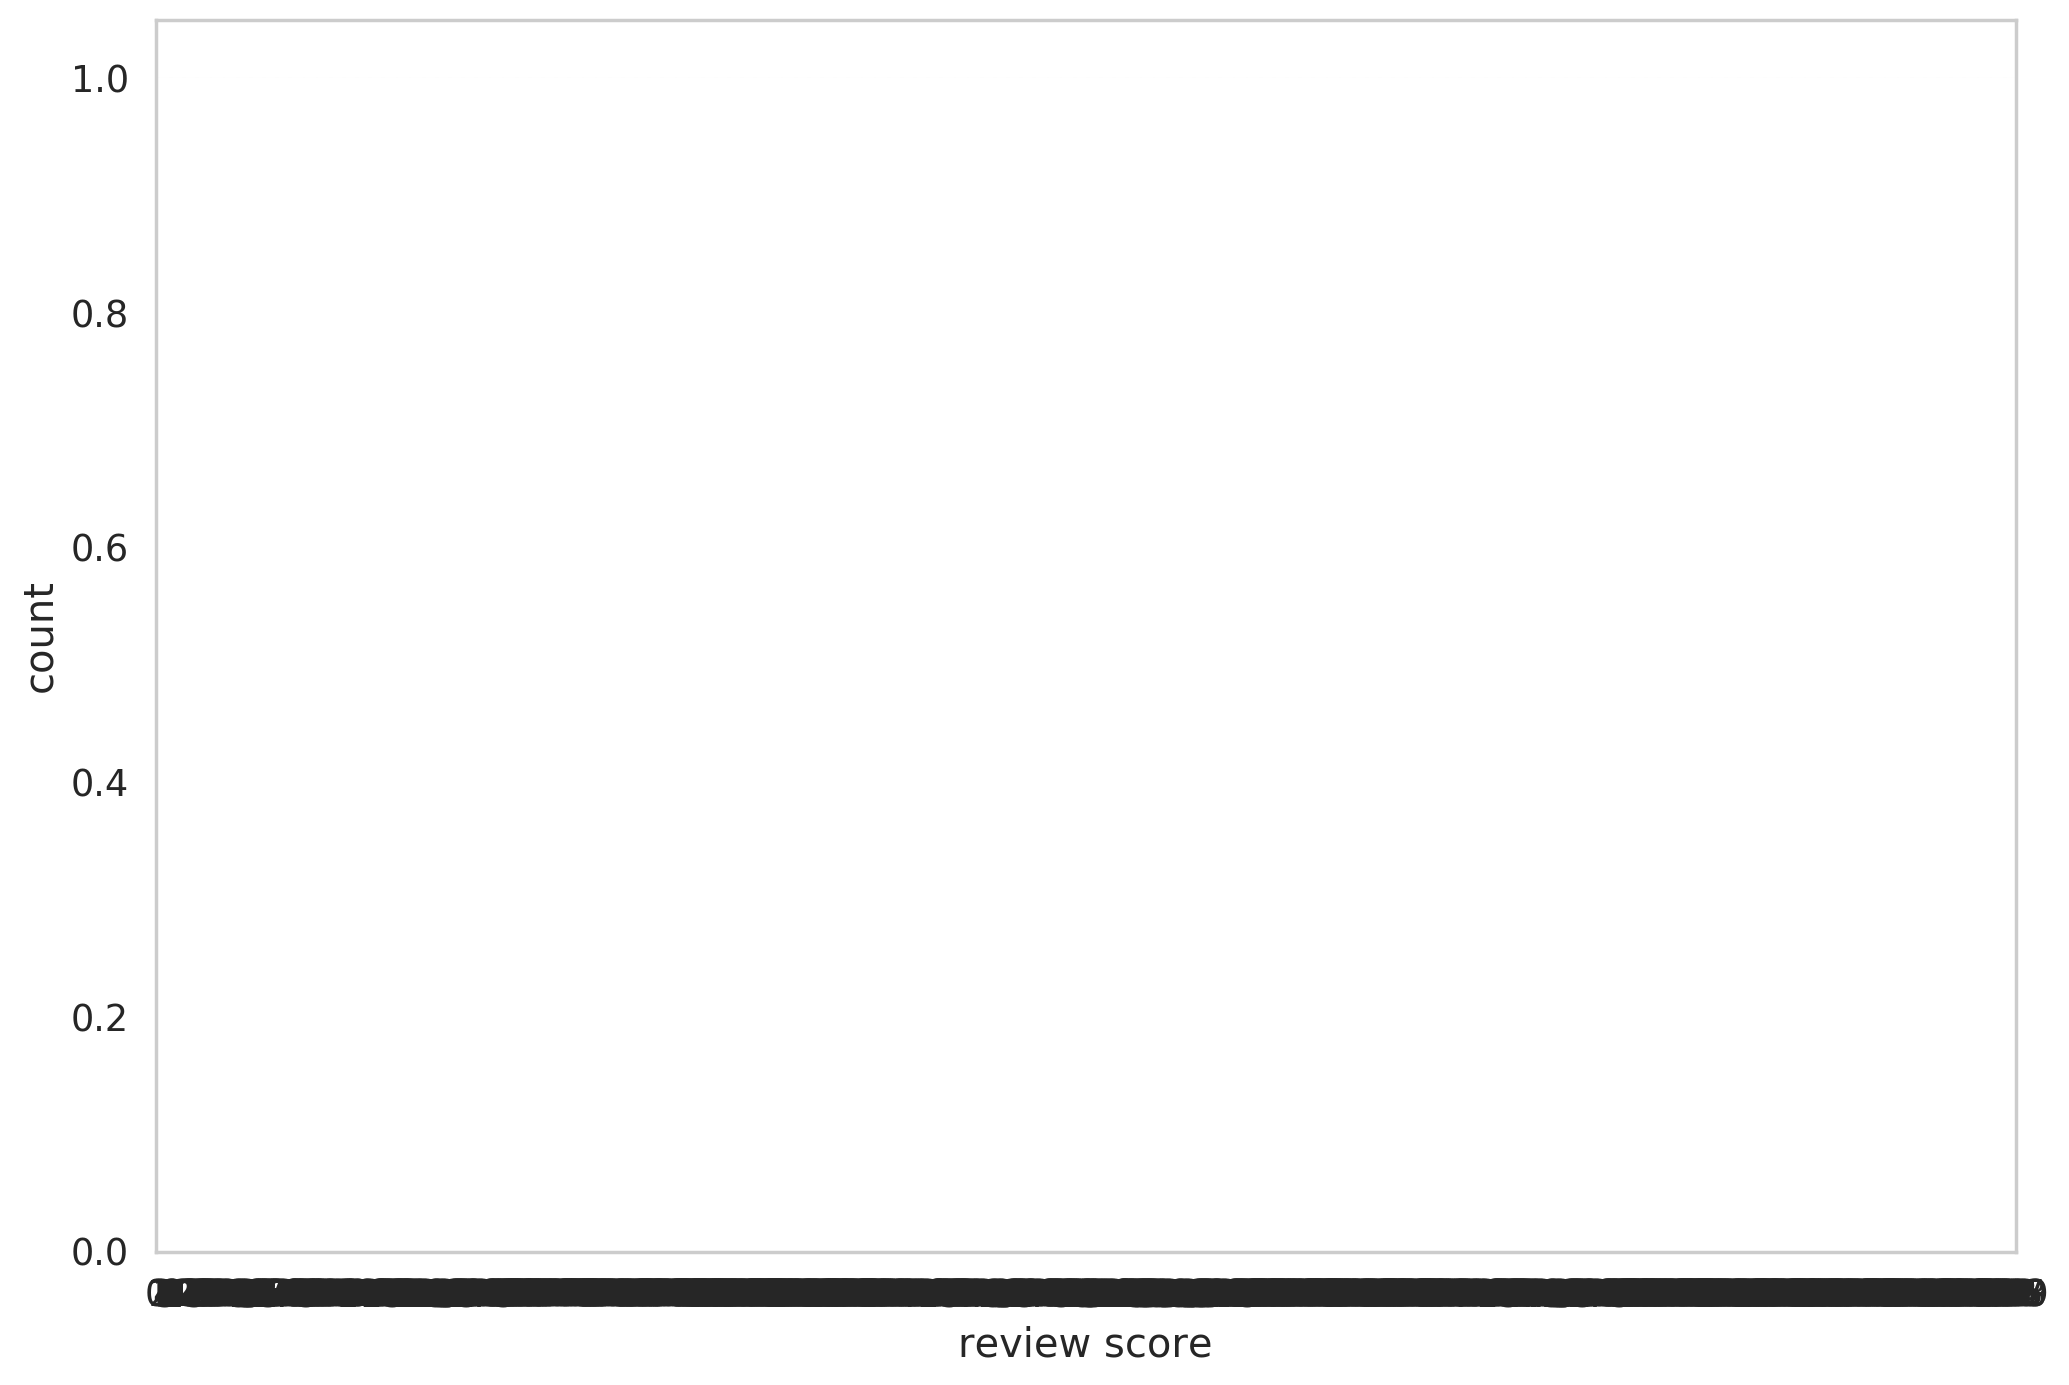

In [10]:
# Let's have a look at the class balance.
sns.countplot(df.label)
plt.xlabel('review score');

We can see that we have more positive classes than negative and low number of neutral class. I have kept neutral less to focus more on positive and negative classes. Let's allot classes based on scores now. 

* 0 - negative
* 1 - neutral 
* 2 - positive

[Text(0, 0, 'not depressed'), Text(0, 0, 'depressed')]

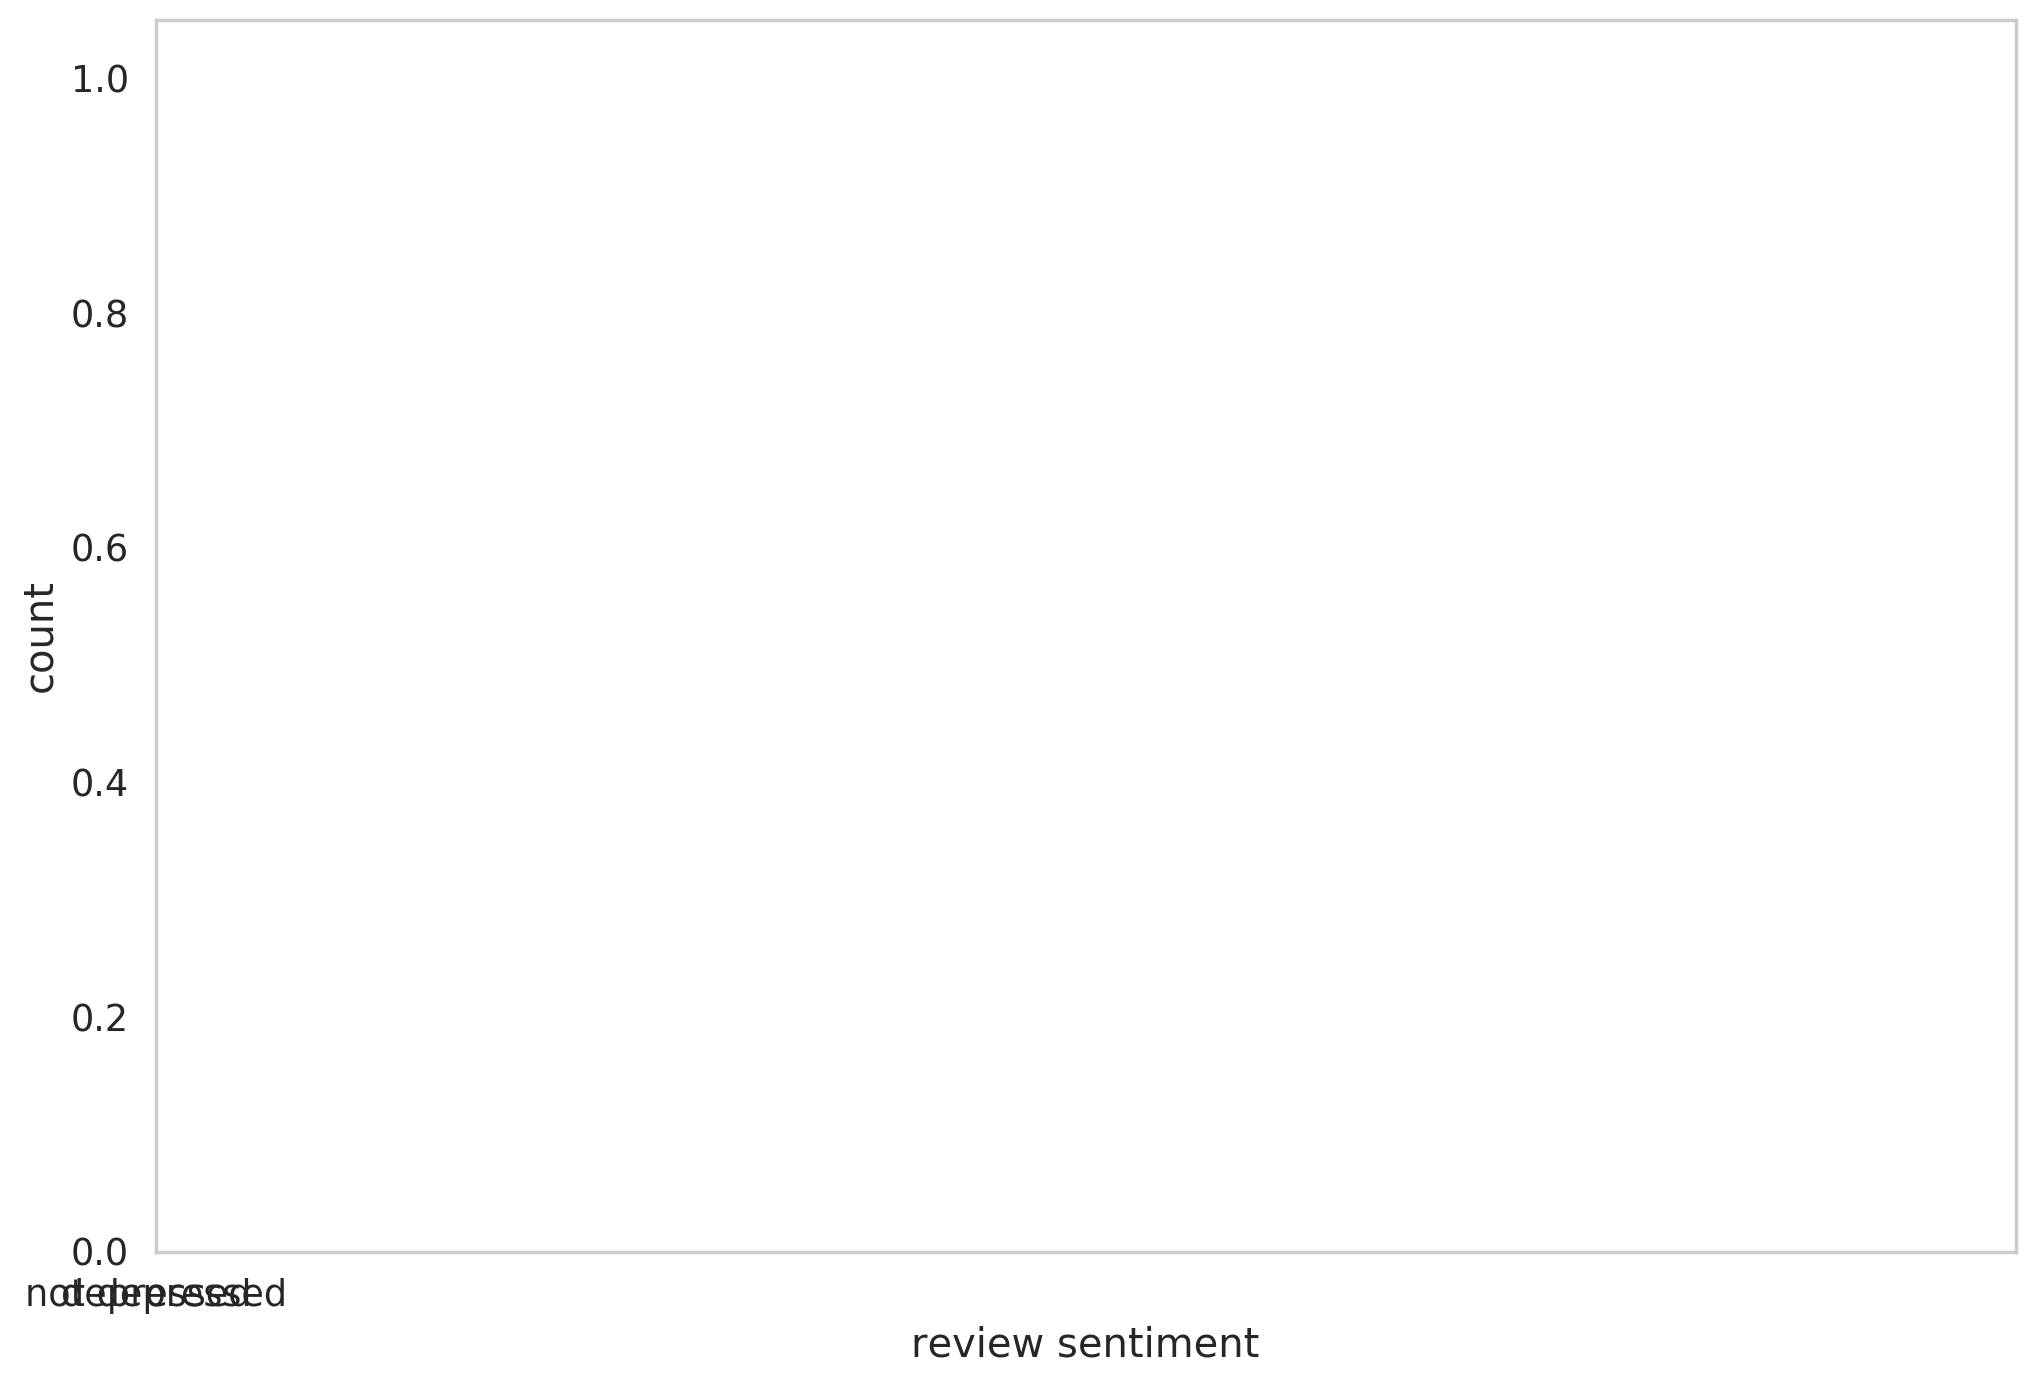

In [75]:
# Plot the distribution
class_names = ['not depressed', 'depressed']
ax = sns.countplot(df.label)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation. 

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word. 

In [76]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, force_download=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [77]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [78]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df.tweet:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


AttributeError: type object 'Line2D' has no attribute 'items'

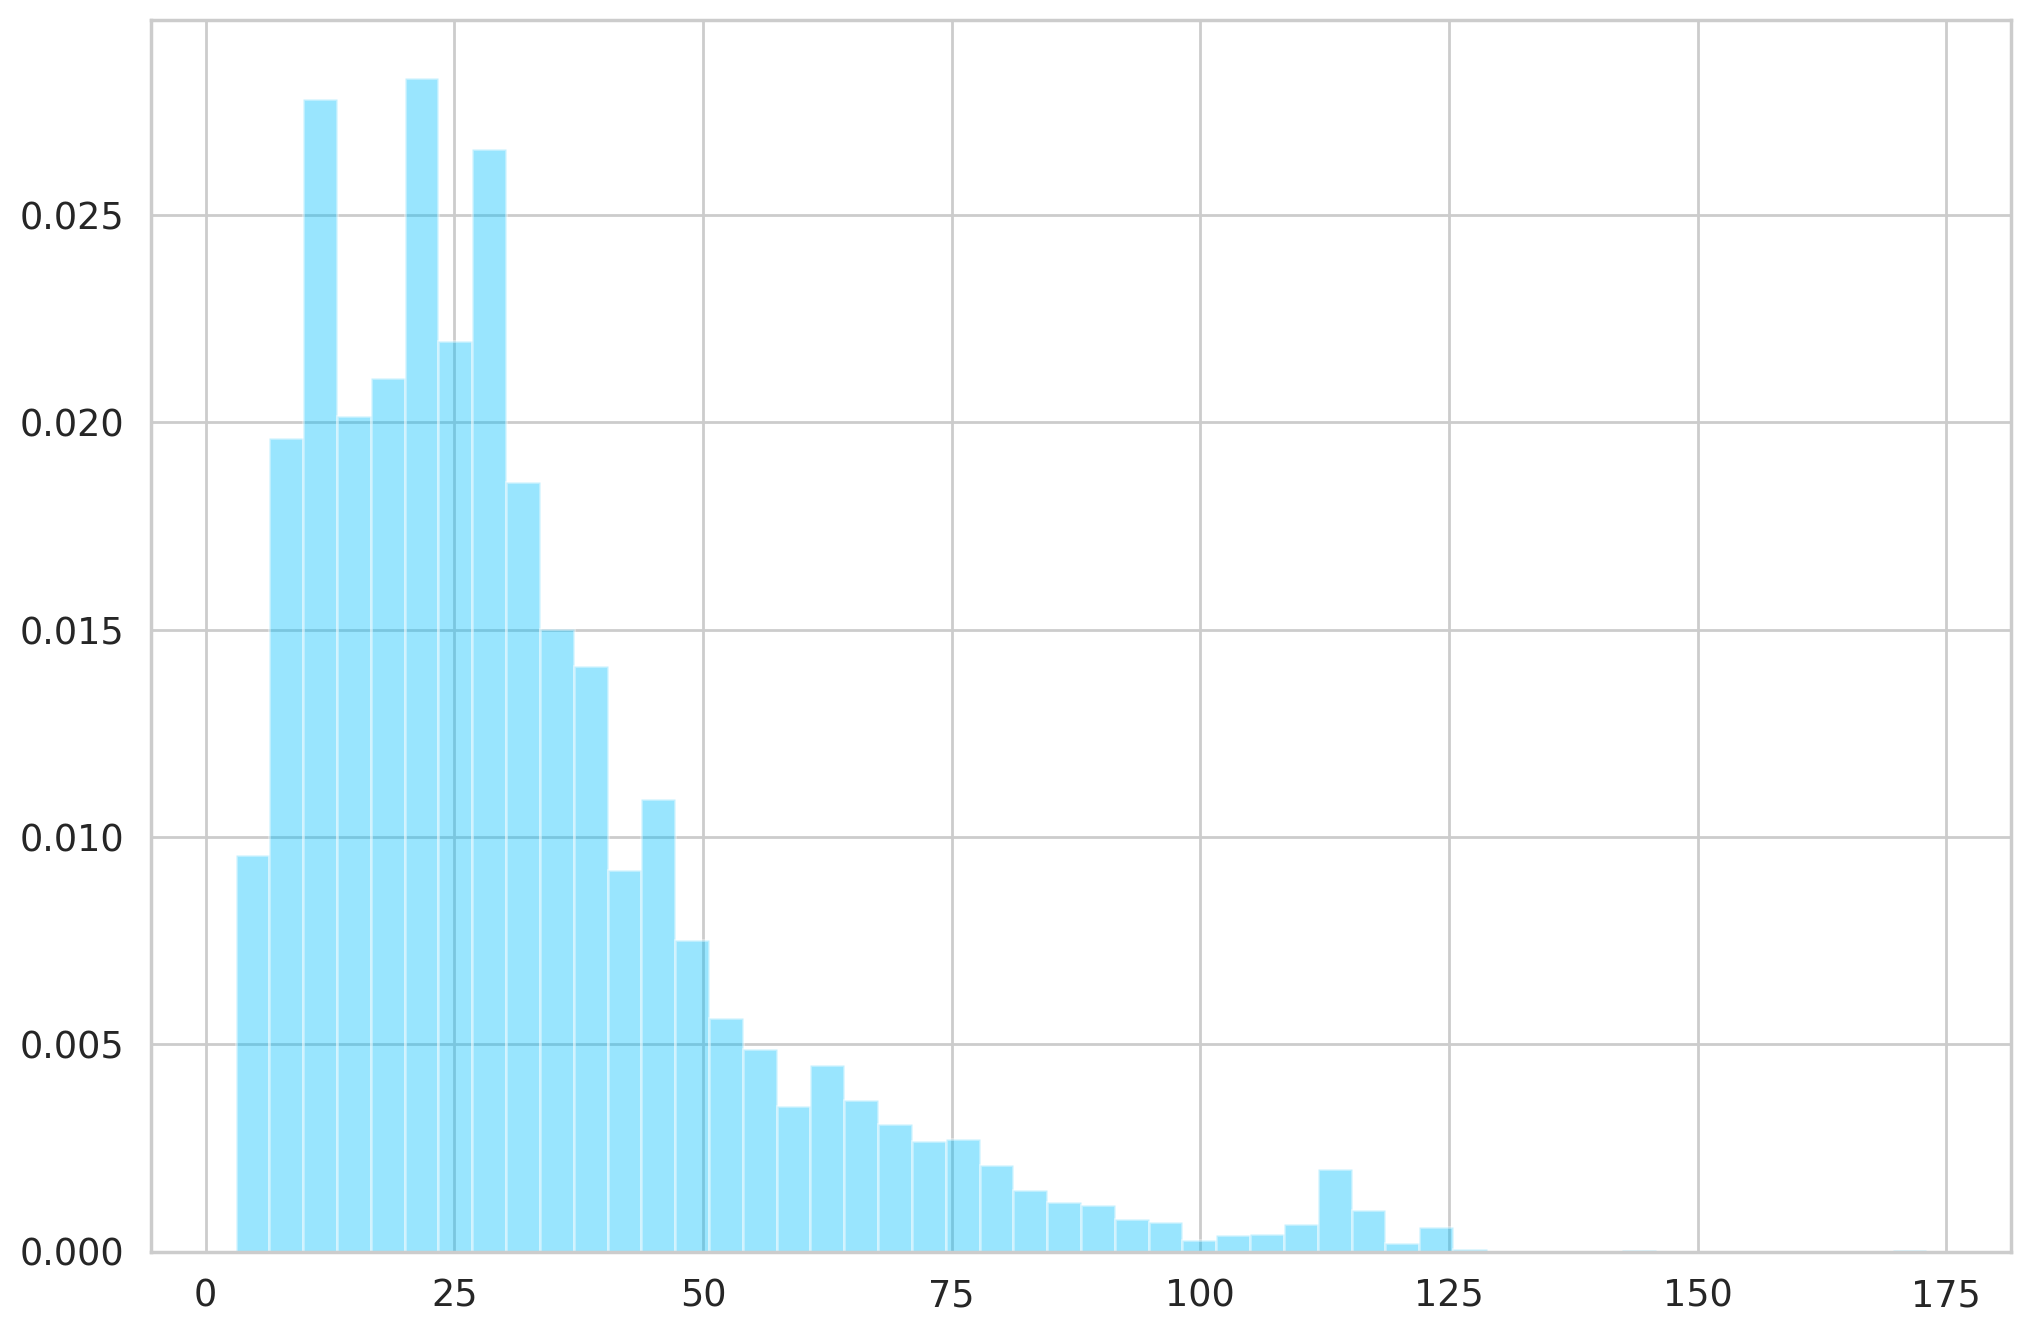

In [79]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160. 

In [ ]:
MAX_LEN = 160

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily. 

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

Create a dataloader to release data in batches.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.tweet.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
data

## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [80]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [81]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [82]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [83]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [84]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [85]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [86]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [87]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [88]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.24205095106299268 accuracy 0.9095424443106562
Val   loss 0.1917017055944038 accuracy 0.9265060240963856

Epoch 2/10
----------
Train loss 0.08763371884609884 accuracy 0.976369656833233
Val   loss 0.2980458025245193 accuracy 0.9289156626506024

Epoch 3/10
----------
Train loss 0.0293823988456377 accuracy 0.9923239012642986
Val   loss 0.3234181326669596 accuracy 0.9349397590361447

Epoch 4/10
----------
Train loss 0.017002657886415855 accuracy 0.9951836243226971
Val   loss 0.3924186115788101 accuracy 0.9349397590361447

Epoch 5/10
----------


KeyboardInterrupt: 

The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

In [81]:
history

defaultdict(list,
            {'train_acc': [tensor(0.4900, device='cuda:0', dtype=torch.float64),
              tensor(0.8475, device='cuda:0', dtype=torch.float64),
              tensor(0.9337, device='cuda:0', dtype=torch.float64),
              tensor(0.9713, device='cuda:0', dtype=torch.float64),
              tensor(0.9838, device='cuda:0', dtype=torch.float64),
              tensor(0.9863, device='cuda:0', dtype=torch.float64),
              tensor(0.9938, device='cuda:0', dtype=torch.float64),
              tensor(0.9975, device='cuda:0', dtype=torch.float64),
              tensor(0.9975, device='cuda:0', dtype=torch.float64),
              tensor(0.9988, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.7388012039661408,
              0.4178780525922775,
              0.22815169874578714,
              0.11812689274083824,
              0.07973141922149807,
              0.061536151831969615,
              0.028202560698846354,
              0.0119448921951

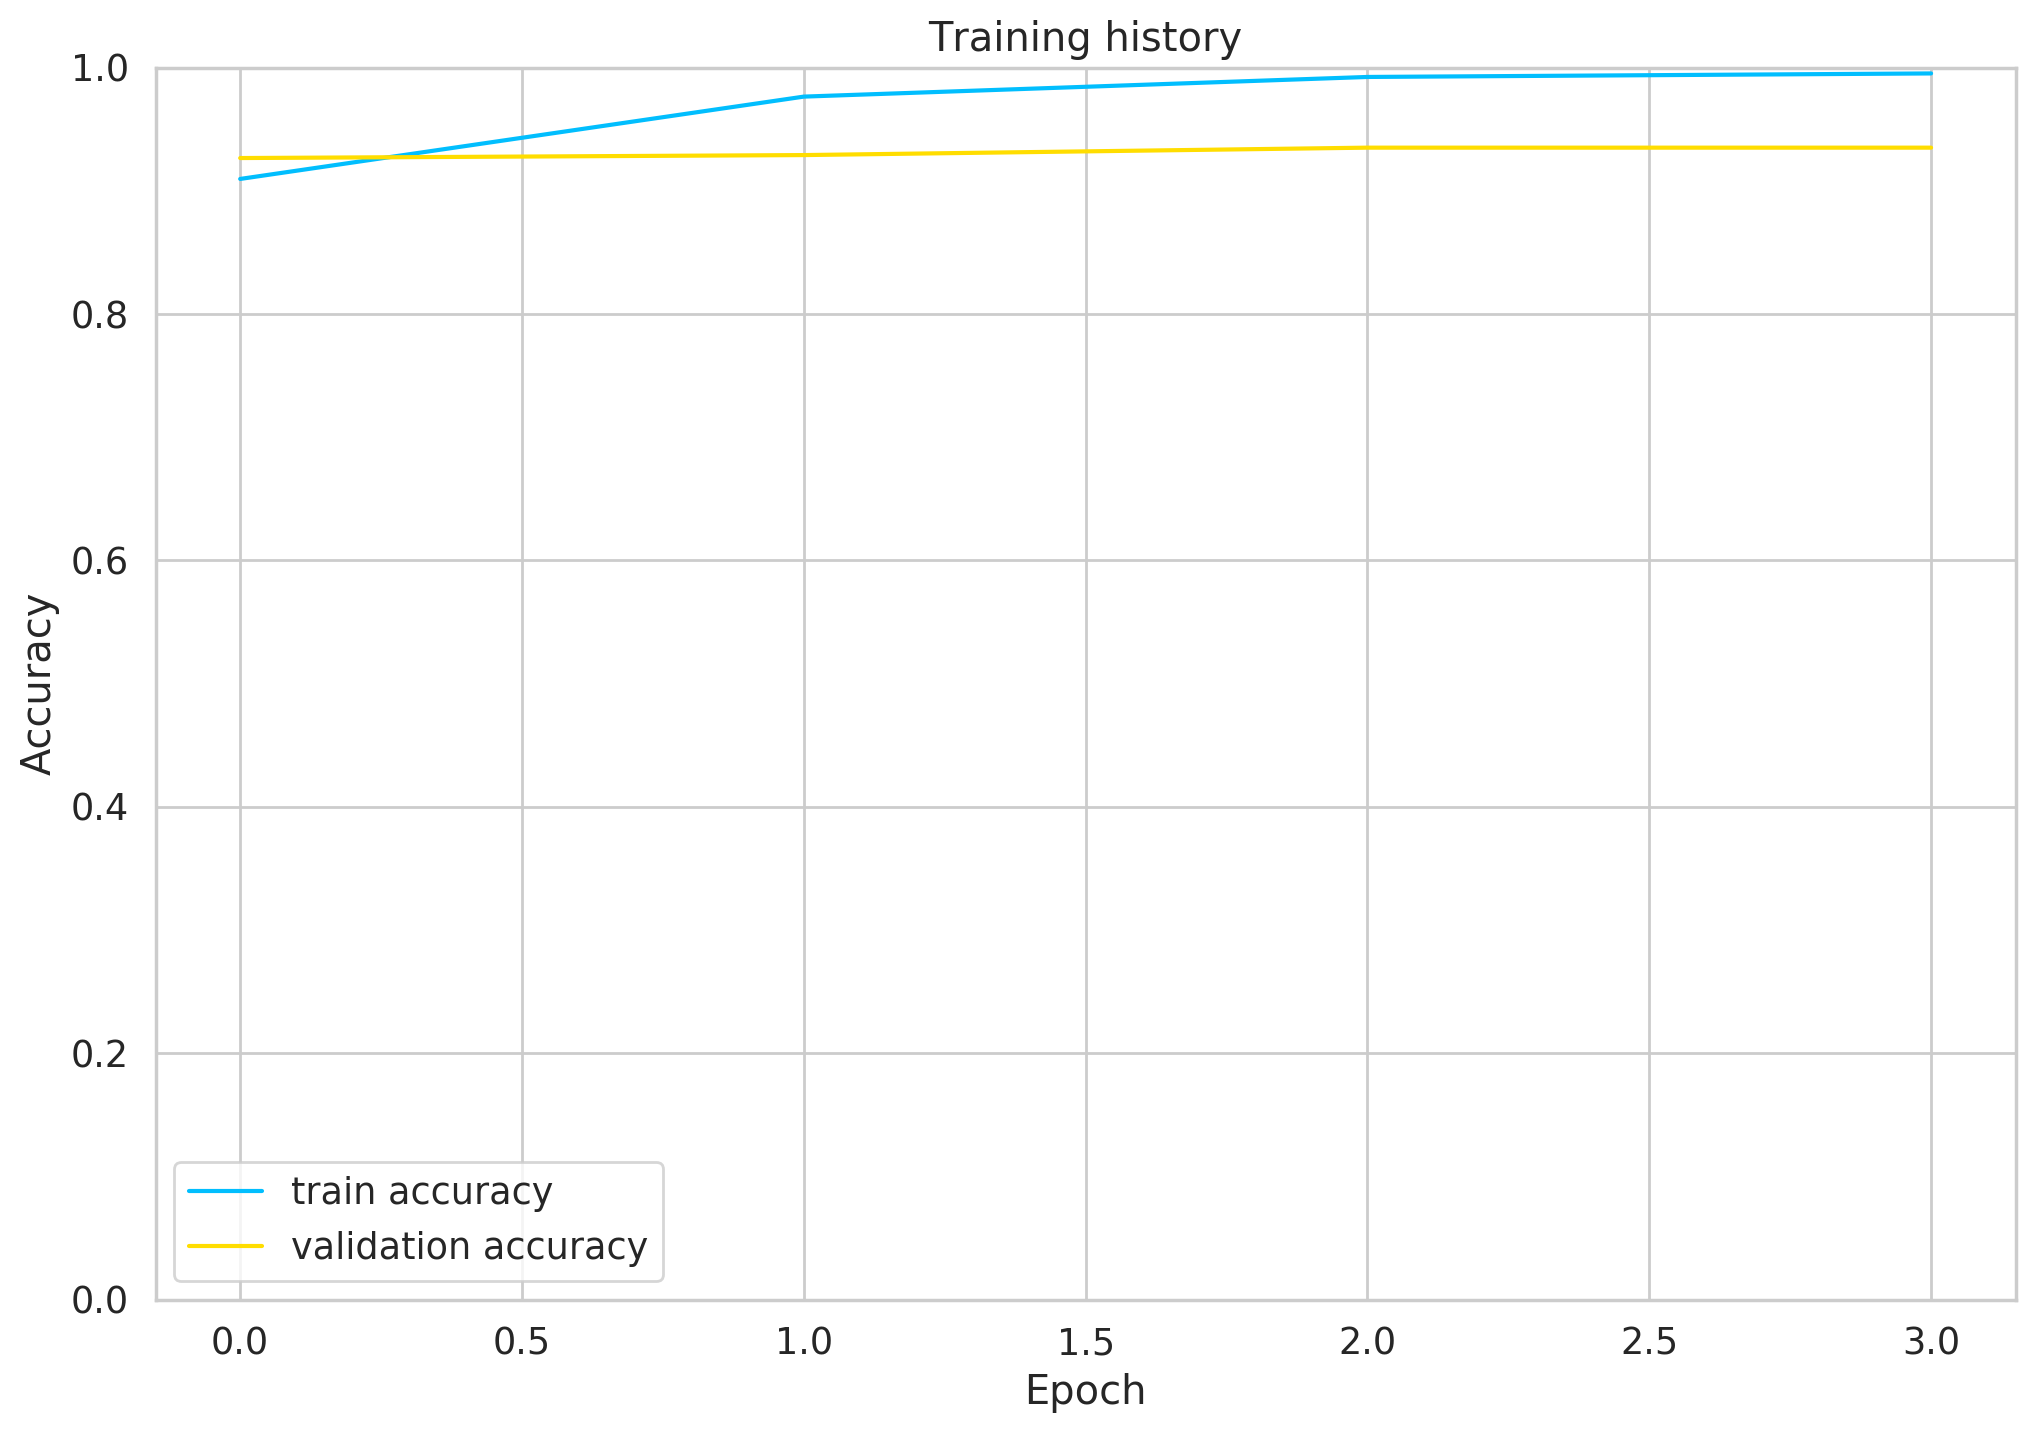

In [89]:
# Plot training and validation accuracy
plt.plot(list(map(lambda x: x.cpu(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.cpu(), history['val_acc'])), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [90]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9542719614921781

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [91]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [92]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [93]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.96      0.96      0.96       481
    depressed       0.95      0.94      0.95       350

     accuracy                           0.95       831
    macro avg       0.95      0.95      0.95       831
 weighted avg       0.95      0.95      0.95       831



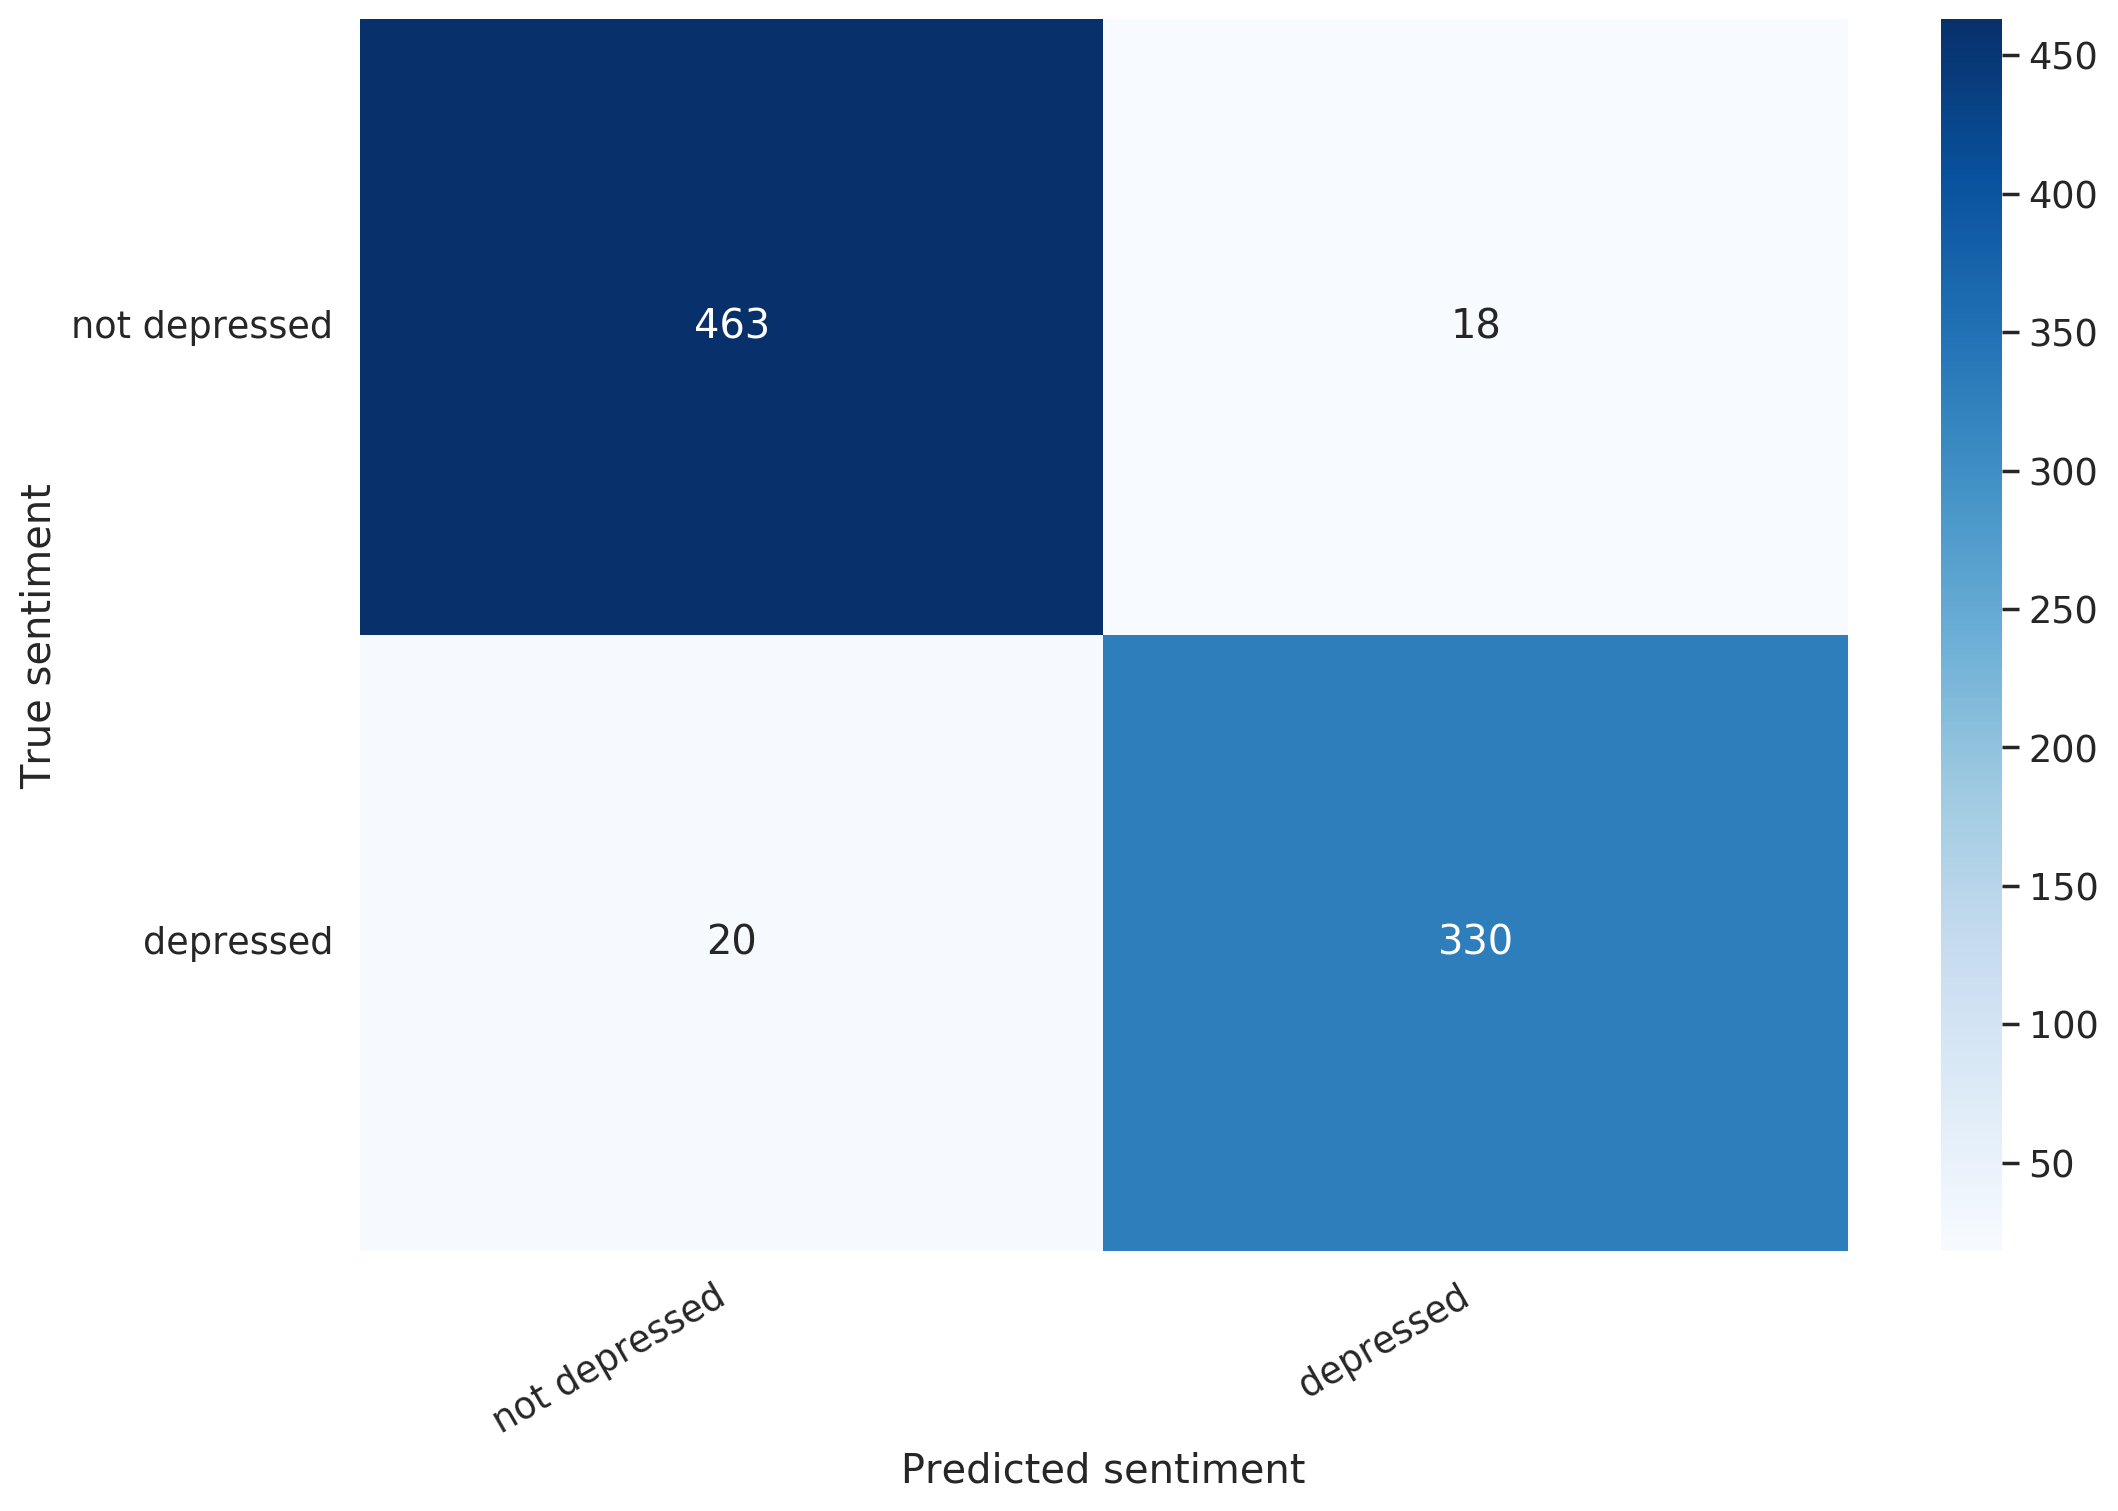

In [94]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [15]:
review_text = "i hate life"

In [16]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

NameError: name 'tokenizer' is not defined

In [17]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

NameError: name 'encoded_review' is not defined